# **Applied Machine Learning**
# **Programming Assignment 3: Stance Classification**
**Group 34**

Dipti Aswal(gusaswdi@student.gu.se)

Atefeh Aminmoghaddam(gusamiat@student.gu.se)

In [1]:
import numpy as np
import pandas as pd
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aswals\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aswals\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Read FINAL training dataset
df_train_final = pd.read_csv("a3_train_final.tsv",sep='\t',header = None)
df_train_final.rename(columns={0:'Labels',1:'Comments'}, inplace=True)

# Read TEST dataset
df_test = pd.read_csv("a3_test.tsv",sep='\t',header = None)
df_test.rename(columns={0:'Labels',1:'Comments'}, inplace=True)

# Check if any rows are blank in either datasets
display(df_train_final.isnull().sum())
display(df_test.isnull().sum())

Labels      0
Comments    0
dtype: int64

Labels      0
Comments    0
dtype: int64

# Calculating the Inter-Annotator Agreement

In [ ]:
# Creating training set
X_train_cohes = df_train_final["Comments"]
y_train_cohes = df_train_final["Labels"]


For calculating the Cohen's kappa coefficient, we considered the two first labels for each instance. Some of the instances which have only one label are removed. Moreover since some of the second annotations were '-1' which are not relevant for calculation the Cohen coefficient, we did not consider these instances in calculating the coefficient.

In [ ]:
annotatore1=[]
annotatore2=[]
annotations_split=[]
for i in range(len(X_train_cohes)):
    annotations_split.append(y_train_cohes[i].split('/'))
    if '-1' not in annotations_split[i]:
          if len(annotations_split[i])>1:
               annotatore1.append(annotations_split[i][0])
               annotatore2.append(annotations_split[i][1])

In [ ]:


ann1= Counter( annotatore1 )

print( ann1.items() )

dict_items([('0', 3735), ('1', 4037)])


In [ ]:


ann2= Counter( annotatore2 )

print( ann2.items() )

dict_items([('0', 3780), ('1', 3992)])


In [ ]:

cohen_kappa_score(annotatore1,annotatore2)

0.8796975006281078

### The final training data contains multiple labels by multiple annotators so we are using the **most frequent occuring label** as the **Truth Label**

In [ ]:

X_train_final = df_train_final["Comments"]
y_train_final = df_train_final["Labels"]

print(len(y_train_final))

annotations_list=[]
truth_label_list = []
for i in range(len(y_train_final)):
    annotations_list.append(y_train_final[i].split('/'))
    #print(annotations_list)
    truth_label_list.append(max(set(annotations_list[i])))

#print(truth_label_list)
df_train_final.insert(1, 'TruthLabels', truth_label_list)
df_train_final.tail()

8788


,Labels,TruthLabels,Comments
8783,1/1,1,💉💪
8784,0/0,0,😐Its gonna be a NO for me.
8785,0/0,0,🤣 keep your 💩 I already know 3 people who have...
8786,0/0,0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D..."
8787,0/0,0,🤨there's people already having severe side eff...


### Check if both the data sets are Balanced

In [ ]:
# Check if the data set is balanced for both labels

print('Frequency of the values in the train dataset')
display(df_train_final['TruthLabels'].value_counts() )
print('Frequency of the values in the test dataset')
display(df_test['Labels'].value_counts() )

Frequency of the values in the train dataset


1    4758
0    4030
Name: TruthLabels, dtype: int64

Frequency of the values in the test dataset


0    198
1    194
Name: Labels, dtype: int64

In [ ]:
# Seperating input and output labels for final training and test sets
X_train_final = df_train_final["Comments"]
y_train_final = df_train_final["TruthLabels"]

X_test = df_test["Comments"]
y_test = df_test["Labels"]

len(X_train_final), len(X_test)

(8788, 392)

### Create function to perform pre-processing for the "Comments" column that contains raw data.
#### 1. Tokenise into alphabetic tokens thus discard numbers and punctuations
#### 2. Lemmatize a Sentence with the appropriate POS tag
#### 3. Stop words are removed
#### 4. min_df = remove tokens that are too rare like less than 20 in this case
#### 5. max_df = remove tokens that occur too frequently, 80% in this case

In [ ]:
## Preprocessing begins ##
# 1. Tokenise into alphabetic tokens thus discard numbers and punctuations
# 2. Lemmatize a Sentence with the appropriate POS tag

def preprocessor(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. POS tagging for adjective, nouns, adverb and verbs
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = nltk.pos_tag(tokens)
    
    # 3. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(i.lower(), pos=pos_map.get(j[0], 'v')) for i, j in pos_tags]
    return tokens

## Preprocessing continued ##
# 3. Stop words are removed
# 4. min_df = remove tokens that are too rare like less than 20 in this case
# 5. max_df = remove tokens that occur too freuently, 80% in this case
vectorizer = TfidfVectorizer(stop_words="english", analyzer=preprocessor, min_df=20, max_df = 0.8,max_features=1000, decode_error="ignore")

X_train_vectorized = vectorizer.fit_transform(X_train_final)
features = vectorizer.get_feature_names()
print(features)

df = pd.DataFrame(X_train_vectorized[1].T.todense(), index=features, columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print ("\n\n",df.head(10))

['a', 'able', 'about', 'absolutely', 'accept', 'accord', 'ache', 'actual', 'actually', 'adverse', 'affect', 'afraid', 'africa', 'after', 'again', 'against', 'age', 'agenda', 'ago', 'agree', 'ahead', 'aid', 'ain', 'alive', 'all', 'allergic', 'allergy', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'always', 'amaze', 'america', 'american', 'among', 'amount', 'an', 'and', 'animal', 'another', 'answer', 'anti', 'antibody', 'antivaxxers', 'any', 'anymore', 'anyone', 'anything', 'anyway', 'appointment', 'approval', 'approve', 'are', 'area', 'aren', 'arm', 'around', 'as', 'asap', 'ask', 'astrazeneca', 'at', 'attack', 'autism', 'autoimmune', 'available', 'avoid', 'away', 'awesome', 'b', 'baby', 'back', 'bad', 'base', 'basically', 'be', 'beast', 'because', 'become', 'before', 'begin', 'behind', 'believe', 'benefit', 'best', 'between', 'big', 'bill', 'billion', 'bit', 'bless', 'blood', 'body', 'boost', 'both', 'brain', 'brilliant', 'bring', 'build', 'business', 'but', 'by', 'c

### Evaluate Multinomial Naive Bayes algorithm as a baseline because of its simplicity.
### Later evaluated Random forest and Support vector machine classifiers
#### We ran randomForest with different max_depths and arrived at best score at max_depth=5.
#### For SVC we did tuning using the kernels values as "linear","poly" and "rbf" and got best score with "rbf"
#### The C and gamma values didnt have much affect on the accuracy hence default values were used.

In [ ]:
# Evaluate Multinomial Naive Bayes(as baseline), Random forest and Support Vector Machine classifier
mnb_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", analyzer=preprocessor, max_features=10000)),
        ("multinomial naive bayes", MultinomialNB())])

#random Forest with max_depth=5
rfc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", analyzer=preprocessor, max_features=10000)),
        ("random forest", RandomForestClassifier(max_depth=5))])

# SVC with kernal="rbf"
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", analyzer=preprocessor, max_features=10000)),
        ("linear svc", SVC(kernel="rbf"))])
   
all_models = [("mnb_tfidf", mnb_tfidf),("rfc_tfidf", rfc_tfidf),("svc_tfidf", svc_tfidf)]
 
scores = [(name, cross_val_score(model, X_train_final, y_train_final, cv=2).mean()) for name, model in all_models]
print(scores)  

[('mnb_tfidf', 0.7802685480200273), ('rfc_tfidf', 0.6100364132908511), ('svc_tfidf', 0.7931269913518434)]


### SVC performed better than randomForest and the baseline model on training set hence using the same. After evaluating the test data on SVC with the kernel as rbf we get a accuracy score of ~90%

In [ ]:
# Evaluating Test set on SVC 
model = svc_tfidf
model.fit(X_train_final, y_train_final)
y_pred = model.predict(X_test)

print(accuracy_score(y_test.astype(str), y_pred.astype(str)))
print(classification_report(y_test.astype(str), y_pred.astype(str)))


0.8954081632653061
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       198
           1       0.86      0.94      0.90       194

    accuracy                           0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



### The numbers shown in dark blue cell below are the **True positives** and **True negatives** (0s and 1s) where the predicted values are same as the truth labels. The numbers in light blue cell are the ones which represent **False positives** and **False Negatives** (where the truth and predicted values differ).

#### After training with SVC the accuracy of test data is ~90% whjch means that 10% of the labels are mis-classified. That is the labels with 0s were actually 1s and vice versa.



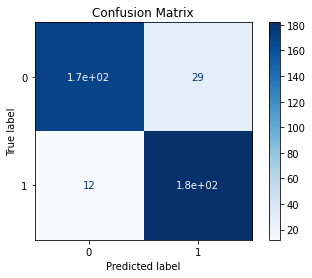

In [ ]:
disp = plot_confusion_matrix(model, X_test.astype(str), y_test.astype(str), cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()
